In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from torchsummary import summary

import matplotlib.pyplot as plt
from hydra import compose, initialize
from omegaconf import OmegaConf

from tqdm import tqdm
import random
import numpy as np

import matplotlib.patches as mpatches

In [2]:
from typing import List, Optional, Tuple

import torch
import hydra
import pyrootutils
import pytorch_lightning as pl
from omegaconf import DictConfig
from pytorch_lightning import (Callback, LightningDataModule, LightningModule,
                               Trainer)
from pytorch_lightning.loggers import TensorBoardLogger

# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)

import src.utils.default as utils

log = utils.get_pylogger(__name__)

torch.set_float32_matmul_precision('medium')
# torch.autograd.set_detect_anomaly(True)

In [3]:
####### CHANGE
EXP_NAME = 'sst-corrected-skullstrip50-unet-allAugm/runs/2023-03-21_16-48-52'
CHKPT = '/mrhome/vladyslavz/git/central-sulcus-analysis/logs/sst-corrected-skullstrip50-unet-allAugm/runs/2023-03-21_16-48-52/checkpoints/epoch-470_val_loss-0.000.ckpt'
####### CHANGE


logging_path = '/mrhome/vladyslavz/git/central-sulcus-analysis/logs'

In [4]:
cfg = OmegaConf.load(f'{logging_path}/{EXP_NAME}/.hydra/config.yaml')

log.info(f"Instantiating datamodule <{cfg.data._target_}>")
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.data)

log.info(f"Instantiating model <{cfg.model._target_}>")
model: LightningModule = hydra.utils.instantiate(cfg.model)


2023-03-21 17:44:25,936 - Len of train examples 16 len of validation examples 4
2023-03-21 17:44:25,937 - Instantiating model <src.models.simclr.SimCLR>


In [5]:
model = model.load_from_checkpoint(CHKPT, encoder=hydra.utils.instantiate(cfg.model.encoder))

In [6]:
def generate_embedings(repeats: int, val_dataset, model):
    res_labels = []
    res_embeds = []
    for i in tqdm(range(repeats)):
        val_imgs = []

        for i in range(len(val_dataset)):
            val_imgs.append(torch.stack(val_dataset[i][0]))
        val_imgs = torch.stack(val_imgs)

        val_embeddings = []
        for i in range(len(val_imgs)):
            with torch.no_grad():
                val_embeddings.append(model(val_imgs[i]))
            
        flat_embed = torch.concat(val_embeddings, dim=0)
        flat_labels = [i for i in range(len(val_embeddings)) for j in range(len(val_embeddings[i]))]
        
        res_labels.extend(flat_labels)
        res_embeds.append(flat_embed)

    return res_labels, torch.stack(res_embeds).squeeze(0).flatten(0,1)

In [7]:
dataset_skullstripped = datamodule.val_dataset
dataset_skullstripped.skull_strip = True

labels_skullrtipped, embeddings_skullrtipped  = generate_embedings(100, dataset_skullstripped, model)

100%|██████████| 100/100 [18:24<00:00, 11.04s/it]


In [8]:
dataset_notskullstripped = datamodule.val_dataset
dataset_notskullstripped.skull_strip = False

labels_notskullstripped, embeddings_notskullstripped  = generate_embedings(100, dataset_notskullstripped, model)
labels_notskullstripped = [x + 4 for x in labels_notskullstripped]

100%|██████████| 100/100 [17:05<00:00, 10.25s/it]


In [9]:
embeddings = torch.concatenate((embeddings_skullrtipped, embeddings_notskullstripped), dim=0)
labels = labels_skullrtipped + labels_notskullstripped

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, n_iter=1000,
            n_jobs=10, perplexity=30.0,)

tsne_results = tsne.fit_transform(embeddings)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.000s...
[t-SNE] Computed neighbors for 1600 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 2.666422
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.290054
[t-SNE] KL divergence after 1000 iterations: 0.140212


In [11]:
all_label_colors = list(plt.get_cmap('tab20').colors)
# random.shuffle(all_label_colors)
all_label_colors = [all_label_colors[i] for i in [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]]
label_colors = [all_label_colors[i] for i in labels]

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


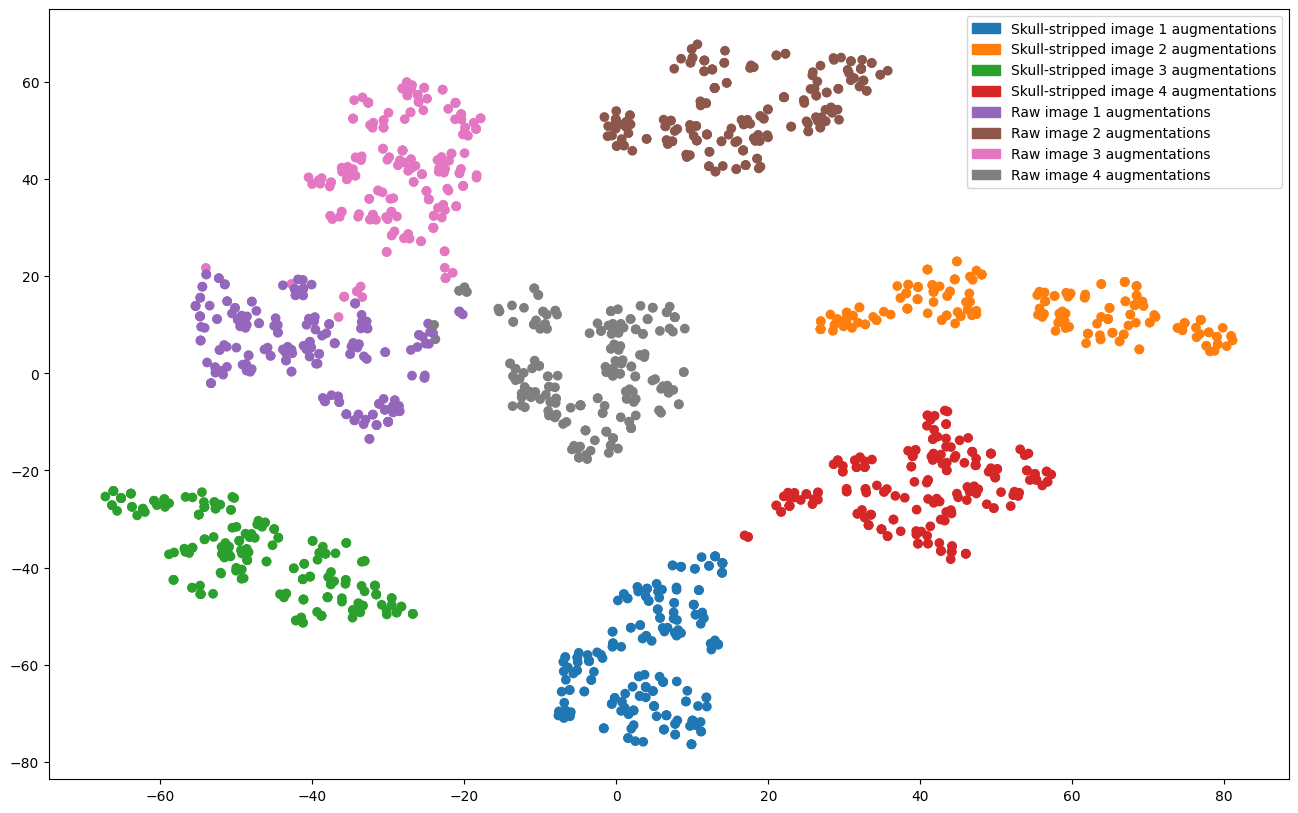

In [12]:
plt.figure(figsize=(16,10))

plt.scatter(tsne_results[:,0], tsne_results[:,1], c=label_colors, cmap='tab20')

patches_list = []

for col in np.unique(labels):
    if col <=3:
        patches_list.append(mpatches.Patch(color=all_label_colors[col], label=f'Skull-stripped image {col + 1} augmentations'))
    else:
        patches_list.append(mpatches.Patch(color=all_label_colors[col], label=f'Raw image {col - 3} augmentations'))

plt.legend(handles=patches_list)

plt.show()